데이터 및 코드: https://github.com/datascienceabe/study_open/tree/master/A_B_testing

참고:  https://github.com/lazyprogrammer/machine_learning_examples/tree/master/ab_testing

# Multi-Armed Bandit

<b>Multi-Armed Bandit 문제</b>
- 3개의 슬롯 머신있는데 돌릴 때마다 돈이 든다고 하고 각 기계의 당첨 확률은 다음과 같다
- 1번 기계: 30% 확률로 당첨
- 2번 기계: 20% 확률로 당첨
- 3번 기계: 10% 확률로 당첨<br>
<br>
- 두 개의 기계로 3번씩만 해봤을 때 어떤 기계는 3번 전부 당첨, 다른 기계는 0번 당첨
- 그러면 1번째 기계가 더 좋은걸까?

<b>Explore-Exploit Deilema</b>
- 첫 번째 기계가 좋았으니 첫 번째 기계를 더 돌려볼까? (Exploit, 일종의 몰빵)
- 첫 번째 기계가 좋았던게 운일 수도 있으니 모든 기계를 랜덤으로 돌려 데이터를 더 모을까? (Explore)
- Explore를 할 수록 정확한 정보를 얻을 수 있지만 비용이 많이 들음
- 좋은 기계에 가능하면 Exploit하고 싶음

<b>A/B Test에의 응용</b>
- A 광고와 B 광고 중 어떤 광고가 좋은 광고인지 알고 싶음
- 하지만 광고 기록 데이터를 수집할 때 마다 비용이 생김 (서버 관리, 시간 등)
- 몇 시간 지켜보니까 A가 좋아보이니까 A 광고를 계속 실는게 좋지 않을까?
- 하지만 A가 일시적으로 좋은 것일 수 있으니까 비용을 들여서라도 조금 더 지켜보는게 좋지 않을까?

# 1. Epsilon Greedy

특정 확률에 따라 랜덤 하게 A나 B를 보거나, 가장 결과가 좋았던 광고를 탐색할지 선택<br>
1) 0에서 1 사이에 매우 작은 epsilon 지정 (exploration 확률)<br>
2) $u\sim Uniform(0,1)$<br>
3) $u<epsilon$=> 광고를 랜덤하게 보여줌<br>
4) $u>epsilon$=> 가장 좋았던 광고 보여줌<br>

- 즉 epsilon 확률로 랜덤하게 보여줄지 가장 좋은거를 보여줄지 선택하는 알고리즘
- 10%의 확률을 탐색하는데 사용
- 그렇다면 $u>epsilon$일 때 가장 좋았던 광고는 어떻게 평가할까?

- 기계의 당첨됐던 평균 $\bar{X}$ 이용
- 하지만 평균을 그냥 계산하면 모든 관측 값들을 이용해야 되서 비효율적
- $\bar{X}_{N} =(1-\frac{1}{N})\bar{X}_{N-1}+\frac{1}{N}X_{N}$: 현재 관측 값과 과거 관측 값의 가중평균 이용

$\epsilon$에 따라 수렴 속도나 정확성이 다를까?

실험 설계
- $\epsilon=0.1, 0.05, 0.01$로 다르게 설정하여 
- 기계 1의 보상: $N(1,1)$에서 랜덤하게
- 기계 2의 보상: $N(2,1)$에서 랜덤하게
- 기계 3의 보상: $N(3,1)$에서 랜덤하게<br>
- 기계의 보상이 같기 때문에 3번 기계를 계속 선택하는 것이 합리적인 상황

<IPython.core.display.Javascript object>


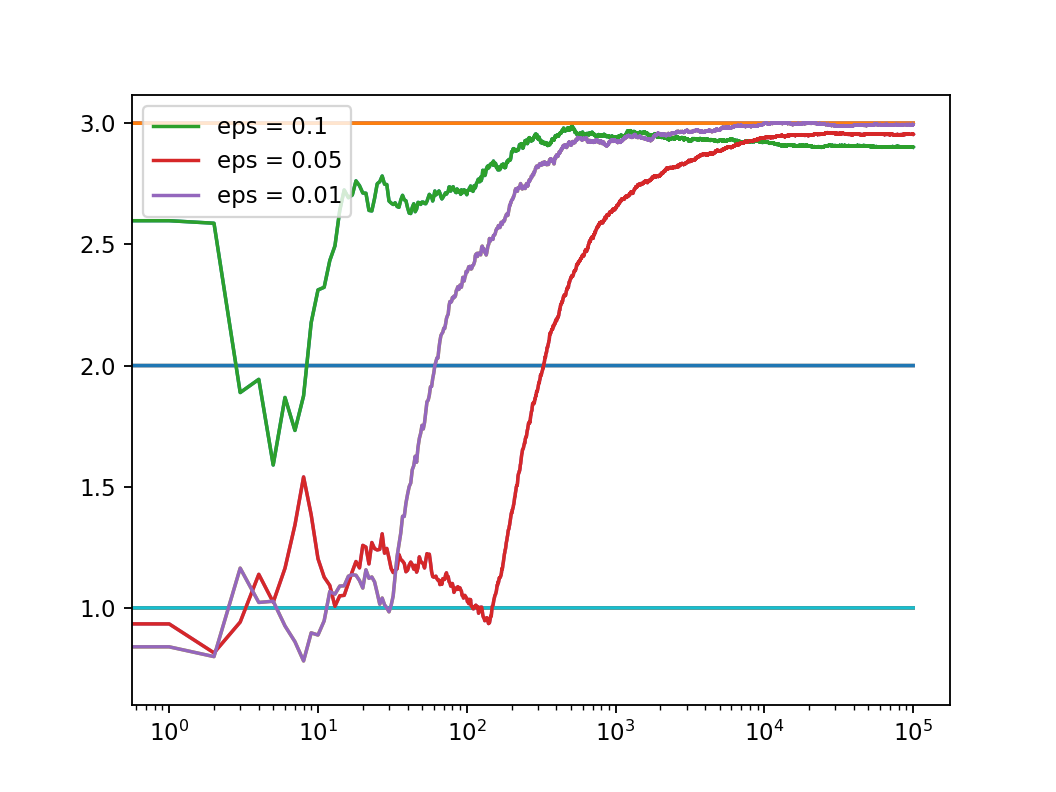

0.9961963609781603
2.0099660634145002
3.002511079730625
1.0180769331037192
2.059272326598047
3.0073996029240337
0.9872185011208632
2.0084037908572268
3.0050124126472832


In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

class Bandit:
  def __init__(self, m):
    self.m = m
    self.mean = 0
    self.N = 0

  def pull(self):
    return np.random.randn() + self.m

  def update(self, x):
    self.N += 1
    self.mean = (1 - 1.0/self.N)*self.mean + 1.0/self.N*x


def run_experiment(m1, m2, m3, eps, N):
  bandits = [Bandit(m1), Bandit(m2), Bandit(m3)]

  data = np.empty(N)
  
  for i in range(N):
    # epsilon greedy
    p = np.random.random()
    if p < eps:
      j = np.random.choice(3)
    else:
      j = np.argmax([b.mean for b in bandits])
    x = bandits[j].pull()
    bandits[j].update(x)

    # for the plot
    data[i] = x
  cumulative_average = np.cumsum(data) / (np.arange(N) + 1)

  # plot moving average ctr
  plt.plot(cumulative_average)
  plt.plot(np.ones(N)*m1)
  plt.plot(np.ones(N)*m2)
  plt.plot(np.ones(N)*m3)
  plt.xscale('log')
  plt.show()

  for b in bandits:
    print(b.mean)

  return cumulative_average

if __name__ == '__main__':
  c_1 = run_experiment(1.0, 2.0, 3.0, 0.1, 100000)
  c_05 = run_experiment(1.0, 2.0, 3.0, 0.05, 100000)
  c_01 = run_experiment(1.0, 2.0, 3.0, 0.01, 100000)

  # log scale plot
  plt.plot(c_1, label='eps = 0.1')
  plt.plot(c_05, label='eps = 0.05')
  plt.plot(c_01, label='eps = 0.01')
  plt.legend()
  plt.xscale('log')
  plt.show()

- x축은 시행 횟수, y축은 평균 보상(당첨)
- 탐색 비용이 가장 높은 $\epsilon=0.1$이 초반 부터 평균 보상이 가장 높고 수렴도 거의 가장 빠름 
- 탐색 비용이 가장 낮은 $\epsilon=0.01$이 초반 부터 평균 보상이 가장 낮고 수렴도 거의 가장 느림 
- 수렴한 이후 부터는 탐색 비용이 낮을 수록 보상이 높아짐
- seed에 따라 달라지는 경우도 있지만 대체로 이러한 경향을 보임<br>
=> 탐색 비용이 높을 수록 초반 보상이 높지만 나중에 가서는 손해

문제점
- 계속 시행하다가 광고 A가 B보다 훨씬 좋은 것을 알게 되도 같은 행동 반복
- A에서 Click을 했을 때 보상이 1, 아닐 때 0이라고 하면 N번 시행 후 보상은 N(1-epsilon/2)로 N보다 낮음
- 만약 epsilon=0.1이라고 하면 보상은 0.95N

# 2. Optimistic Initial Values

만약 모든 기계의 보상이 10보다 작은 것을 알 때는?
- 초기 값을 높게 잡으면 진행하면서 점점 작아져서 수렴을 잘할 것 (낙관적 초기값 설정)
- 만약 실제 평균이 1로 낮다면 => exploitation을 통해 진짜 평균 값으로 낮아질 것
- 만약 다른 기계들을 충분히 탐색하지 않았다면=> 평균 보상이 여전히 높아 더 많은 탐색을 하게 됨
- Epsilon의 설정이 필요 없음

알고리즘<br>
1) A,B,C는 각각 10으로 설정
2) 3개 중 하나를 땡김<br>
3) 만약 B가 선택 되었고 보상이 없었음 => B=5로 낮아짐<br>
3) A,C는 10으로 가장 높기 때문에 둘 중 하나를 땡김<br>
4) 만약 A가 선택 되었고 보상이 2였음 => A=6으로 낮아짐<br>
5) 이제 C가 제일 높기 때문에 C를 땡김
6) 이 과정 계속 반복

<IPython.core.display.Javascript object>


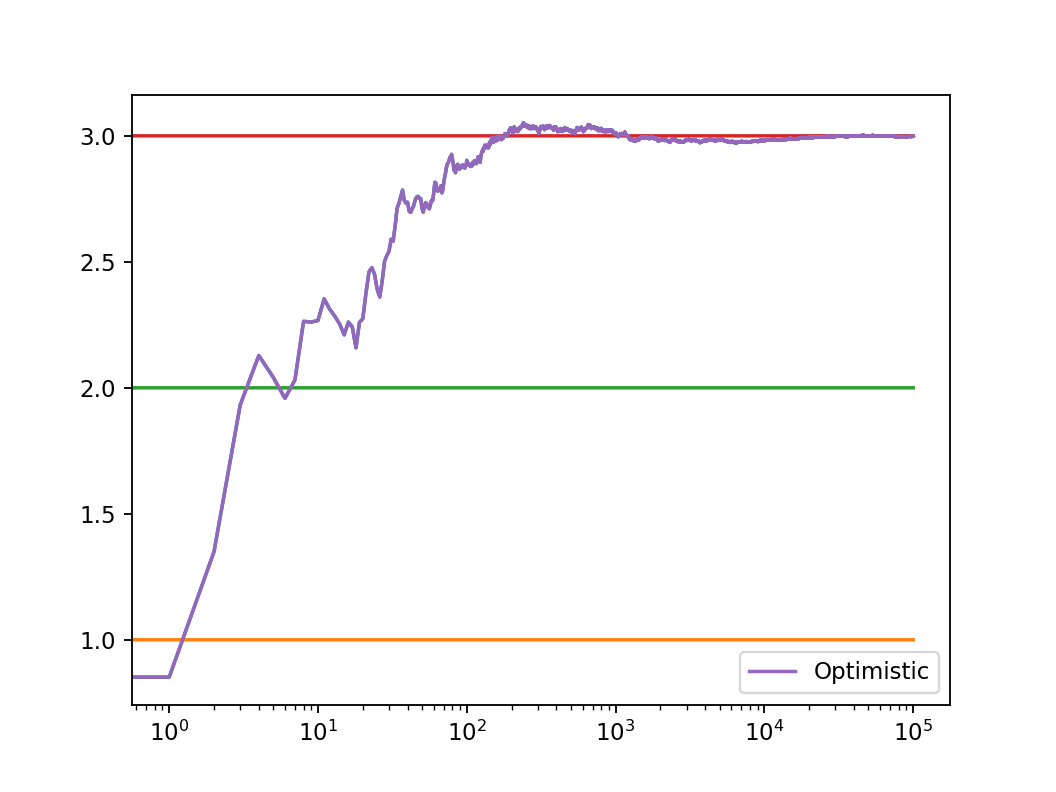

0.8570203322105155
0.8464662837944859
2.9980743581160434


In [3]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

class Bandit:
  def __init__(self, m):
    self.m = m
    self.mean = 10
    self.N = 0

  def pull(self):
    return np.random.randn() + self.m

  def update(self, x):
    self.N += 1
    self.mean = (1 - 1.0/self.N)*self.mean + 1.0/self.N*x


def run_experiment(m1, m2, m3, N):
  bandits = [Bandit(m1), Bandit(m2), Bandit(m3)]

  data = np.empty(N)
  
  for i in range(N):

    j = np.argmax([b.mean for b in bandits])
    x = bandits[j].pull()
    bandits[j].update(x)

    # for the plot
    data[i] = x
  cumulative_average = np.cumsum(data) / (np.arange(N) + 1)

  # plot moving average ctr
  plt.plot(cumulative_average)
  plt.plot(np.ones(N)*m1)
  plt.plot(np.ones(N)*m2)
  plt.plot(np.ones(N)*m3)
  plt.xscale('log')
  plt.show()

  for b in bandits:
    print(b.mean)

  return cumulative_average

if __name__ == '__main__':
  c_1 = run_experiment(1.0, 2.0, 3.0,  100000)

  # log scale plot
  plt.plot(c_1, label='Optimistic')
  plt.legend()
  plt.xscale('log')
  plt.show()

# 3. UCB1 (Upper Confidence Bound 1)

샘플이 너무 적으면 신뢰 구간이 넓어짐 (기각을 못함)
- 더 타이트한 Upper bound가 있을 때 최대 승률에 대한 확신을 갖게 됨


Chernoff-Hoeffding bound
- 정규 분포의 신뢰구간 보다 더 타이트함
- $\epsilon>0$ 일때 $P(\bar{X}>\mu+\epsilon) \le exp(-2\epsilon^2 N)     $ 은 항상 성립 (부등호 반대도 성립)
- 전개 하면 $P(|\bar{X}-\mu|\le \epsilon) >1- 2exp(-2\epsilon^2 N)     $
- Upper bound에만 관심
- 샘플이 많아질 수록 신뢰구간이 지수적으로 감소


$X_{UCB-j}$<br>
- $\epsilon = \sqrt{ \frac{2lnN}{N_{j}}  }$으로 설정
- $X_{UCB-j}=\bar{X}+\sqrt{ \frac{2lnN}{N_{j}}  }$
- N은 게임을 지금까지 플레이한 총 횟수
- $N_{j}$는 기계당 지금까지 플레이한 횟수

적용 방법
- $X_{UCB-j}$에 대해 greedy한 접근
- 만약 $N_{j}$만 낮음 => upper bound가 매우 큼
- 만약 $N_{j}$만 큼 => upper bound가 매우 작음
- $lnN$은 $N_{j}$보다 증가 속도가 작음 => 따라서 모든 신뢰 구간은 시행 횟수에 따라 줄어 들음
- 큰데서 작은데로 점점 줄여간다는 점이 Optimistic Initial Value랑 비슷

Pseudo code<br>
- $N=0$<br>
- $N_{j}=0$<br>
- While True:<br>
- $ j^{*}=\arg\max_{j}(\bar{X}_{j}+\sqrt{ \frac{2lnN}{N_{j}}  }) $<br>
play arm $j^{*}$<br>
- update $\bar{X}$<br>
- $N++,N_{j}++$

<IPython.core.display.Javascript object>


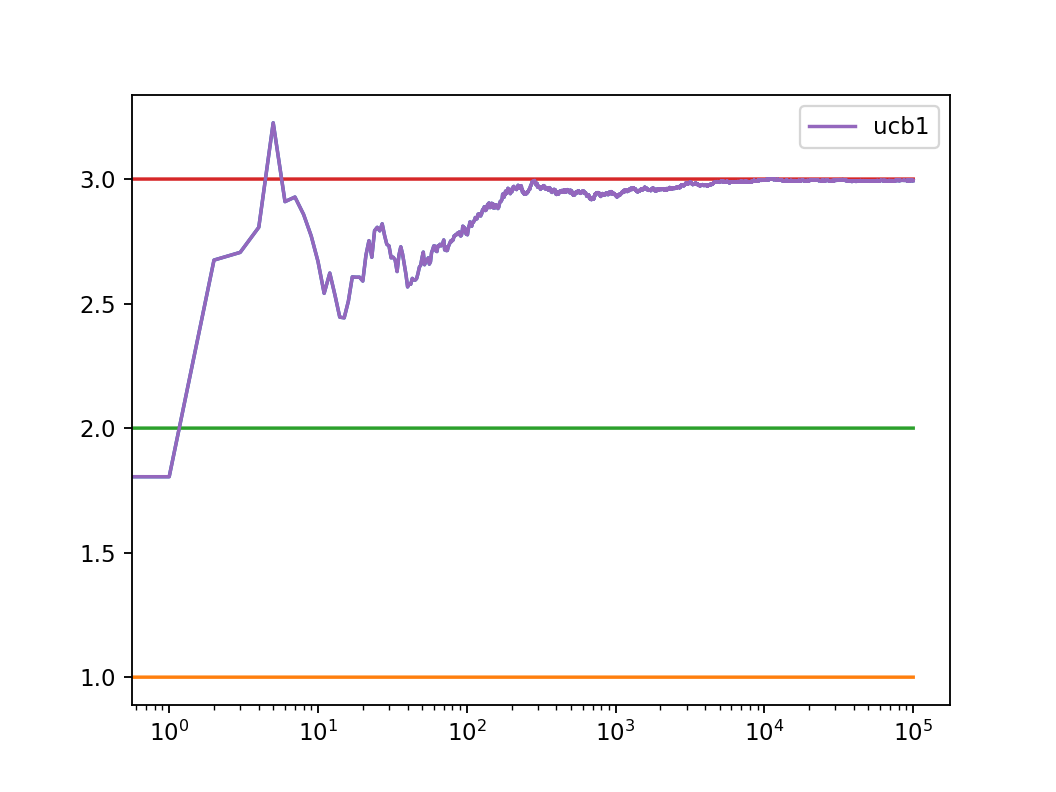

In [4]:
%matplotlib notebook
class Bandit:
  def __init__(self, m):
    self.m = m
    self.mean = 0
    self.N = 0

  def pull(self):
    return np.random.randn() + self.m

  def update(self, x):
    self.N += 1
    self.mean = (1 - 1.0/self.N)*self.mean + 1.0/self.N*x


def ucb(mean, n, nj):
  if nj == 0:
    return float('inf')
  return mean + np.sqrt(2*np.log(n) / nj)


def run_experiment(m1, m2, m3, N):
  bandits = [Bandit(m1), Bandit(m2), Bandit(m3)]

  data = np.empty(N)
  
  for i in range(N):
    j = np.argmax([ucb(b.mean, i+1, b.N) for b in bandits])
    x = bandits[j].pull()
    bandits[j].update(x)

    # for the plot
    data[i] = x
  cumulative_average = np.cumsum(data) / (np.arange(N) + 1)

  # for b in bandits:
  #   print("bandit nj:", b.N)

  # plot moving average ctr
  plt.plot(cumulative_average)
  plt.plot(np.ones(N)*m1)
  plt.plot(np.ones(N)*m2)
  plt.plot(np.ones(N)*m3)
  plt.xscale('log')
  plt.show()

  # for b in bandits:
  #   print(b.mean)

  return cumulative_average

if __name__ == '__main__':
  ucb = run_experiment(1.0, 2.0, 3.0, 100000)

  # log scale plot
  plt.plot(ucb, label='ucb1')
  plt.legend()
  plt.xscale('log')
  plt.show()


- 수렴하면 거의 3의 값에 가까워짐

# 4. Thompson Sampling

- Thompson Sampling은 베이지안 방법을 이용해 Multi-armed bandit 문제 해결<br>
- 각 기계의 사후 확률의 최대화 하는 샘플을 선택
- 데이터가 들어올 수록 분포가 점차 업데이트 되어 자동적으로 exploration을 할지 exploitation을 할지 조절
- Explore: 데이터가 적음 =>분포가 뚱뚱해짐=> 높은 값을 샘플링
- Exploit: 데이터가 많아짐=> 분포가 얇아짐=> 실제 참 값 부근에서 샘플링

Bayesian A/B Testing
- 데이터의 분포:$X_{j}|\theta_{j} \sim Bernoulli(\theta_{j})$<br>
- 사전 분포:$\theta_{j}\sim Beta(\alpha_{j},\beta_{j})$<br>
- 사후 분포$\theta_{j}|X_{j} \sim Beta(X_{j}+\alpha_{j},1-X_{j}+\beta_{j})$

실험 설계: 사후 분포에서 샘플링한 값이 높은 기계 업데이트<br>
1) $\theta_{j}\sim Beta(\alpha_{j},\beta_{j})$ :모든 기계에서 $\theta$를 샘플링<br>
2) $j^{*}$: 가장 높은 확률의 샘플을 주는 기계<br>
3) $x$: 기계 $j^{*}$로 게임<br>
4) $aj^{*}$=$aj^{*}+x$<br>
5) $bj^{*}$=$aj^{*}+x$

알고리즘 쉽게 이해하기<br>
<br>
Bandit이 당첨 될 진짜 확률이 1번: 0.2, 2번:0.5,3번: 0.75라고 가정<br>
1) $\theta_{j}^{(1)}\sim Beta(\alpha_{j}=1,\beta_{j}=1)$<br>
2) $\theta_{1}^{(1)}=0.26,\theta_{j}^{(2)}=0.74,\theta_{j}^{(3)}=0.38 $<br>
3) 2번째 bandit이 가장 높으므로 2번째 bandit 당김<br>
4) $X_{2}~Bernoulli(0.5)$<br>
5) 담청 됨: X=1<br>
6) 2번 사후 확률 업데이트: $\theta_{2}^{(1)}\sim Beta(\alpha_{2}=1,\beta_{2}=1)$<br>
7) 이와 같은 과정 t=1부터 20000까지


current samples: ['0.0472', '0.7505', '0.7819']


<IPython.core.display.Javascript object>


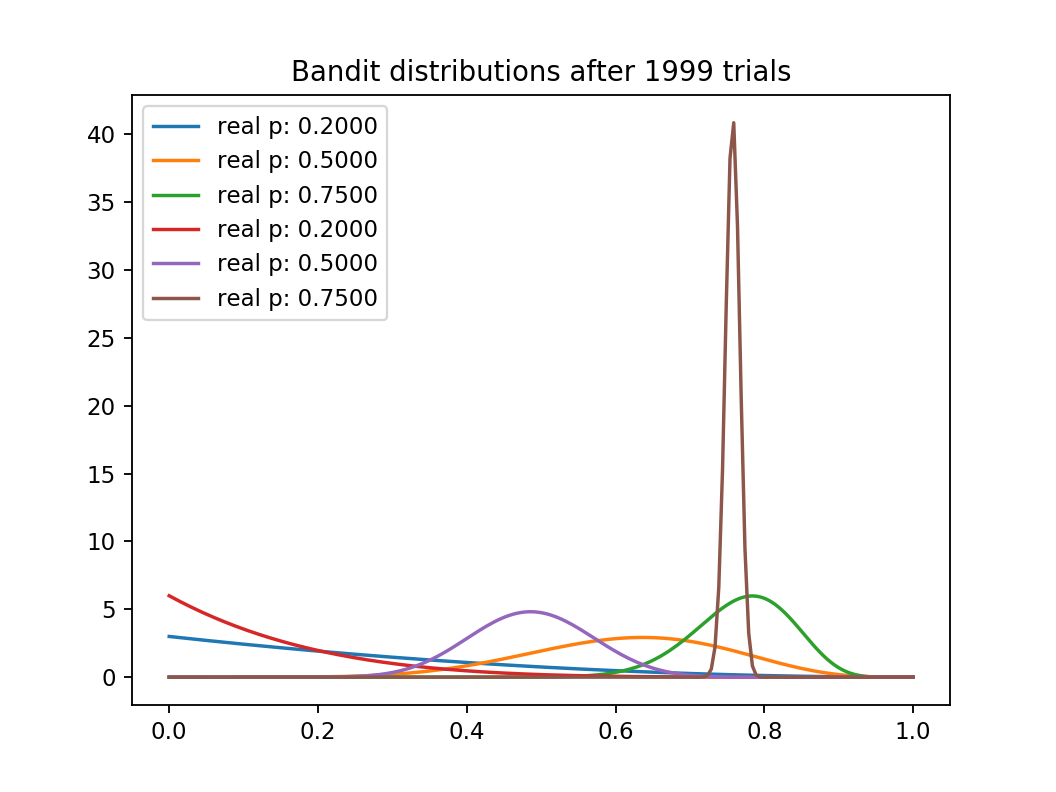

current samples: ['0.2529', '0.4191', '0.7566']


In [5]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta


NUM_TRIALS = 2000
BANDIT_PROBABILITIES = [0.2, 0.5, 0.75]


class Bandit(object):
  def __init__(self, p):
    self.p = p
    self.a = 1
    self.b = 1

  def pull(self):
    return np.random.random() < self.p

  def sample(self):
    return np.random.beta(self.a, self.b)

  def update(self, x):
    self.a += x
    self.b += 1 - x


def plot(bandits, trial):
  x = np.linspace(0, 1, 200)
  for b in bandits:
    y = beta.pdf(x, b.a, b.b)
    plt.plot(x, y, label="real p: %.4f" % b.p)
  plt.title("Bandit distributions after %s trials" % trial)
  plt.legend()
  plt.show()


def experiment():
  bandits = [Bandit(p) for p in BANDIT_PROBABILITIES]

  sample_points = [50, 1999]
  for i in range(NUM_TRIALS):

    # take a sample from each bandit
    bestb = None
    maxsample = -1
    allsamples = [] # let's collect these just to print for debugging
    for b in bandits:
      sample = b.sample()
      allsamples.append("%.4f" % sample)
      if sample > maxsample:
        maxsample = sample
        bestb = b
    if i in sample_points:
      print("current samples: %s" % allsamples)
      plot(bandits, i)

    # pull the arm for the bandit with the largest sample
    x = bestb.pull()

    # update the distribution for the bandit whose arm we just pulled
    bestb.update(x)


if __name__ == "__main__":
  experiment()

결과
- 5번 시뮬레이션: 1번,2번, 3번 모두 분산이 큼
- 20번 시뮬레이션: 3번이 0.9정도 지점에서 치솟음
- 50번 시뮬레이션: 1번은 가장 왼쪽에 있으면서 분산이 매우 높고 3번은 점점 뾰족 2번은 점점 뾰족하나 3번 보다 낮음
- 500번 시뮬레이션: 3번이 심하게 뾰족하고 거의 0.8이 중심이 되고 1번이 가장 낮고 2번이 그 다음
- 2000번 정도 했을 때 거의 정확해짐

결과 해석
- 사후 분포가 데이터가 많아질 수록 점점 더 얇아짐 (분산이 작아짐) => 데이터가 많아질 수록 추정량에 대한 확신이 강해져서

수렴성 진단
- CTR이 가장 좋은 bandit에 수렴할까?

<IPython.core.display.Javascript object>


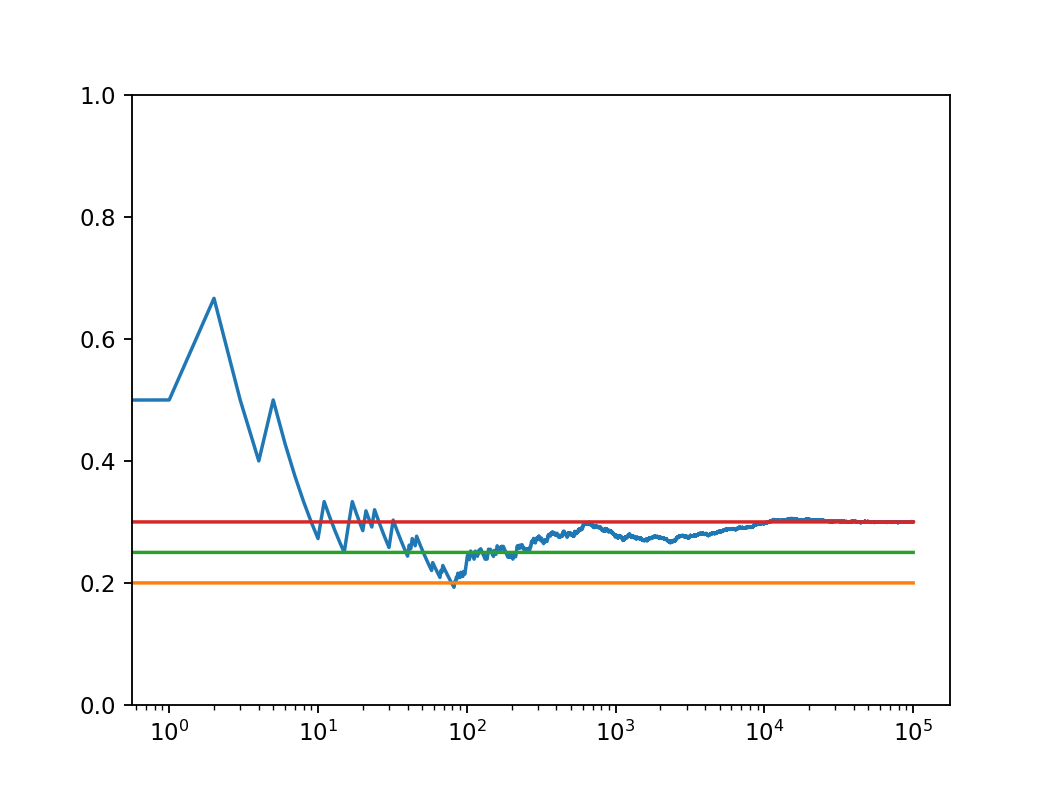

In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

def run_experiment(p1, p2, p3, N):
  bandits = [Bandit(p1), Bandit(p2), Bandit(p3)]

  data = np.empty(N)
  
  for i in range(N):
    # thompson sampling
    j = np.argmax([b.sample() for b in bandits])
    x = bandits[j].pull()
    bandits[j].update(x)

    # for the plot
    data[i] = x
  cumulative_average_ctr = np.cumsum(data) / (np.arange(N) + 1)

  # plot moving average ctr
  plt.plot(cumulative_average_ctr)
  plt.plot(np.ones(N)*p1)
  plt.plot(np.ones(N)*p2)
  plt.plot(np.ones(N)*p3)
  plt.ylim((0,1))
  plt.xscale('log')
  plt.show()


run_experiment(0.2, 0.25, 0.3, 100000) 

- 10,000번 정도 쯤에 가장 좋은 3번 bandit에 수렴

# 5. 비교 

4가지 방법 중에 어떤 것이 가장 뛰어날까?
- 4가지 방법 모두 결국에는 수렴하지만 현실 문제에서는 얼마나 빨리 수렴하는지가 중요할 수 있음

- Epsiolon Greedy 방법은  A가 B보다 훨씬 좋은 것을 알게 되도 같은 행동 반복하기 때문에 성능이 가장 안 좋음
- $\epsilon=\frac{1}{t}$로 설정해 점차 작아지는 adaptive한 방법 사용

In [ ]:
%matplotlib notebook
from os import chdir
chdir('C:/Users/bki19/Desktop/A_B_testing/code')
import numpy as np
import matplotlib.pyplot as plt
from comparing_epsilons import Bandit
from optimistic_initial_values import run_experiment as run_experiment_oiv
from ucb1 import run_experiment as run_experiment_ucb


class BayesianBandit:
  def __init__(self, true_mean):
    self.true_mean = true_mean
    # parameters for mu - prior is N(0,1)
    self.predicted_mean = 0
    self.lambda_ = 1
    self.sum_x = 0 # for convenience
    self.tau = 1

  def pull(self):
    return np.random.randn() + self.true_mean

  def sample(self):
    return np.random.randn() / np.sqrt(self.lambda_) + self.predicted_mean

  def update(self, x):
    self.lambda_ += self.tau
    self.sum_x += x
    self.predicted_mean = self.tau*self.sum_x / self.lambda_


def run_experiment_decaying_epsilon(m1, m2, m3, N):
  bandits = [Bandit(m1), Bandit(m2), Bandit(m3)]

  data = np.empty(N)
  
  for i in range(N):
    # epsilon greedy
    p = np.random.random()
    if p < 1.0/(i+1):
      j = np.random.choice(3)
    else:
      j = np.argmax([b.mean for b in bandits])
    x = bandits[j].pull()
    bandits[j].update(x)

    # for the plot
    data[i] = x
  cumulative_average = np.cumsum(data) / (np.arange(N) + 1)

  # plot moving average ctr
  plt.plot(cumulative_average)
  plt.plot(np.ones(N)*m1)
  plt.plot(np.ones(N)*m2)
  plt.plot(np.ones(N)*m3)
  plt.xscale('log')
  plt.show()

  for b in bandits:
    print(b.mean)

  return cumulative_average


def run_experiment(m1, m2, m3, N):
  bandits = [BayesianBandit(m1), BayesianBandit(m2), BayesianBandit(m3)]

  data = np.empty(N)
  
  for i in range(N):
    # optimistic initial values
    j = np.argmax([b.sample() for b in bandits])
    x = bandits[j].pull()
    bandits[j].update(x)

    # for the plot
    data[i] = x
  cumulative_average = np.cumsum(data) / (np.arange(N) + 1)

  # plot moving average ctr
  plt.plot(cumulative_average)
  plt.plot(np.ones(N)*m1)
  plt.plot(np.ones(N)*m2)
  plt.plot(np.ones(N)*m3)
  plt.xscale('log')
  plt.show()

  return cumulative_average

if __name__ == '__main__':
  m1 = 1.0
  m2 = 2.0
  m3 = 3.0
  eps = run_experiment_decaying_epsilon(m1, m2, m3, 100000)
  oiv = run_experiment_oiv(m1, m2, m3, 100000)
  ucb = run_experiment_ucb(m1, m2, m3, 100000)
  bayes = run_experiment(m1, m2, m3, 100000)

  # log scale plot
  plt.plot(eps, label='decaying-epsilon-greedy')
  plt.plot(oiv, label='optimistic')
  plt.plot(ucb, label='ucb1')
  plt.plot(bayes, label='bayesian')
  plt.legend()
  plt.xscale('log')
  plt.show()


  # linear plot
  plt.plot(eps, label='decaying-epsilon-greedy')
  plt.plot(oiv, label='optimistic')
  plt.plot(ucb, label='ucb1')
  plt.plot(bayes, label='bayesian')
  plt.legend()
  plt.show()


- 진행할 수록 점차 4가지 방법 모두 큰 차이가 없음